# Clinical Trial Data Analysis: Statistical Testing (Mann Whitney Test) and Volcano/\PCA

Overview:
This project involves analyzing clinical trial data, which contains multiple features (such as measurements of subjects at different timepoints). The goal was to perform statistical testing and dimensionality reduction to explore the relationships between timepoints and features, and to visualize patterns.

Lets first create some fake data

In [ ]:
import pandas as pd
import numpy as np

# Parameters
num_subjects = 50  # Number of subjects
num_features = 20  # Number of features
timepoints = ['1d', '5d', '10d', '15d']  # Timepoints

# Generate data
data = []
for subject in range(1, num_subjects + 1):
    for timepoint in timepoints:
        row = {'Subject': f'Subject{subject}', 'Timepoint': timepoint}
        row.update({f'Feature{i+1}': np.random.normal(loc=100 + i*10, scale=10) for i in range(num_features)})
        data.append(row)

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv("clinical_trial_data.csv", index=False)

print("Synthetic dataset generated and saved as 'clinical_trial_data.csv'.")


Synthetic dataset generated and saved as 'clinical_trial_data.csv'.


Now lets write the code that will perform Mann Whitney and create visualisations

    Feature Timepoint1 Timepoint2  Statistic   P-value  -log10(P-value)
0  Feature1         1d         5d     1243.0  0.964259         0.015806
1  Feature1         1d        10d     1446.0  0.177741         0.750211
2  Feature1         1d        15d     1370.0  0.410047         0.387167
3  Feature1         5d        10d     1492.0  0.095941         1.017995
4  Feature1         5d        15d     1395.0  0.319174         0.495973


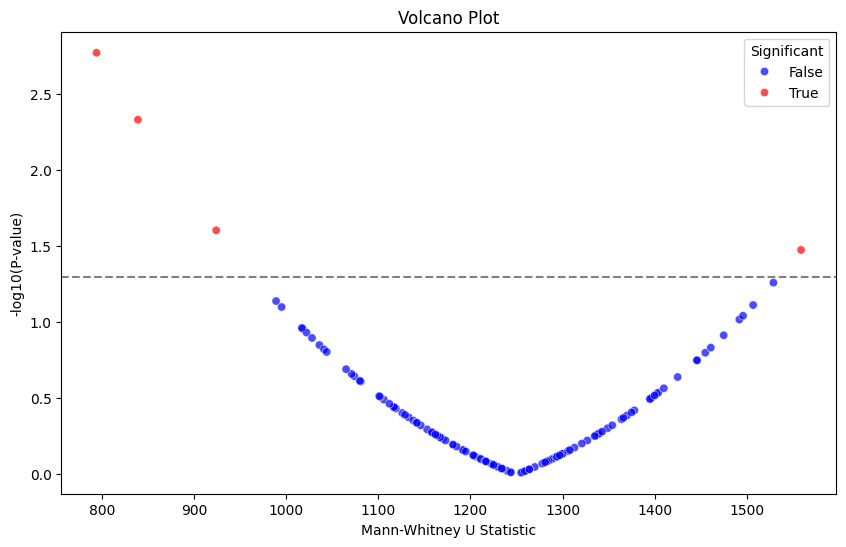

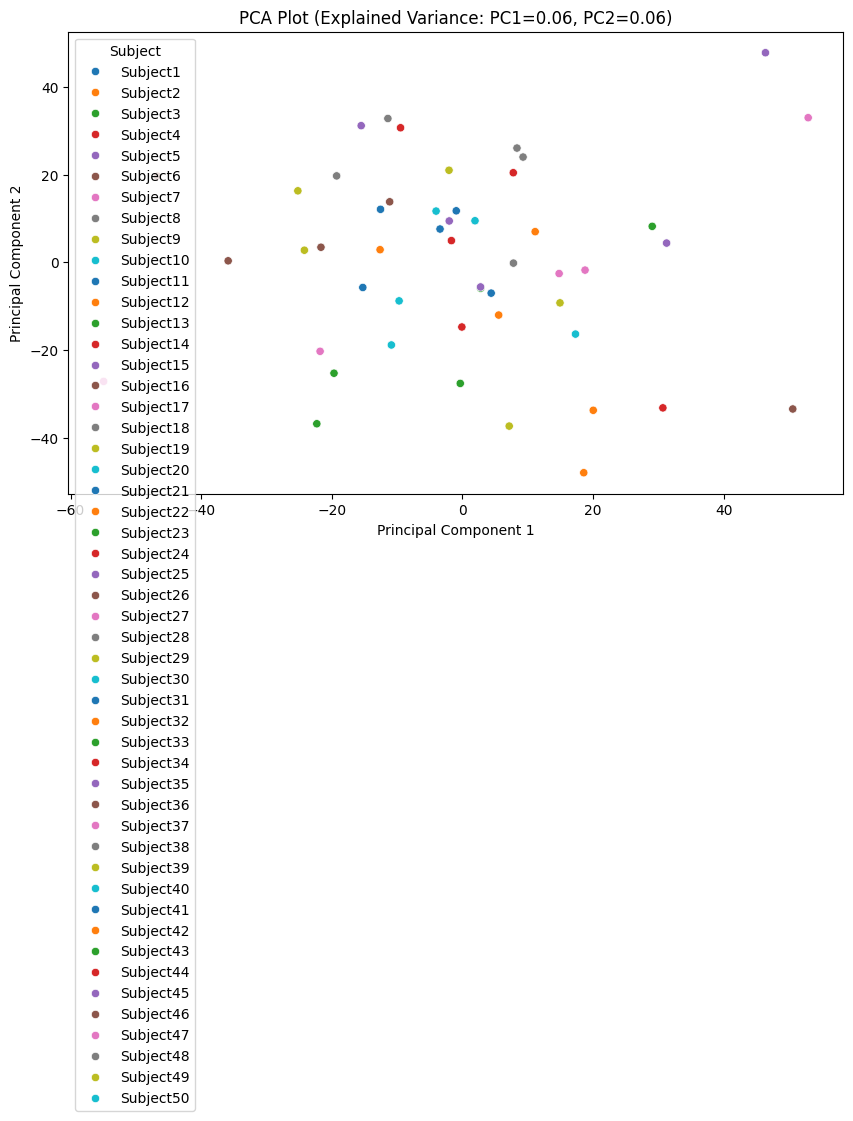

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Assuming the CSV file is named 'clinical_trial_data_long_format.csv'
# Columns include: 'Subject', 'Timepoint', 'Feature1', 'Feature2', ..., 'Feature1000'
data = pd.read_csv("clinical_trial_data.csv")

# Ensure 'Timepoint' column exists
if 'Timepoint' not in data.columns:
    raise ValueError("The dataset must contain a 'Timepoint' column.")

# Extract unique timepoints
timepoints = data['Timepoint'].unique()

# Perform Mann-Whitney U Tests for each feature across timepoints
results = []
features = [col for col in data.columns if col not in ['Subject', 'Timepoint']]

for feature in features:
    for i in range(len(timepoints)):
        for j in range(i + 1, len(timepoints)):
            group1 = data[data['Timepoint'] == timepoints[i]][feature]
            group2 = data[data['Timepoint'] == timepoints[j]][feature]
            stat, p_value = mannwhitneyu(group1, group2)
            results.append({
                'Feature': feature,
                'Timepoint1': timepoints[i],
                'Timepoint2': timepoints[j],
                'Statistic': stat,
                'P-value': p_value
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df['-log10(P-value)'] = -np.log10(results_df['P-value'])

# Display the results
print(results_df.head())

# Save results to a CSV
results_df.to_csv("mann_whitney_results_long_format.csv", index=False)

# Volcano Plot
significance_threshold = 0.05
results_df['Significant'] = results_df['P-value'] < significance_threshold

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Statistic",
    y="-log10(P-value)",
    hue="Significant",
    data=results_df,
    palette={True: "red", False: "blue"},
    alpha=0.7
)
plt.title("Volcano Plot")
plt.xlabel("Mann-Whitney U Statistic")
plt.ylabel("-log10(P-value)")
plt.axhline(-np.log10(significance_threshold), color="gray", linestyle="--")
plt.legend(title="Significant")
plt.savefig("volcano_plot_long_format.png")
plt.show()

# PCA Analysis
# Pivot the data for PCA
pivot_data = data.pivot(index='Subject', columns='Timepoint', values=features)
pivot_data = pivot_data.fillna(0)  # Handle missing values
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pivot_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Subject'] = data['Subject'].unique()  # Use 'Subject' as a column

# Plot PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Subject", data=pca_df, palette="tab10")
plt.title(f"PCA Plot (Explained Variance: PC1={explained_variance[0]:.2f}, PC2={explained_variance[1]:.2f})")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig("pca_plot_long_format.png")
plt.show()
